### **DATASET OVERVIEW**

1. **Index**: row index of the game in the table.
2. **Name**: the name of the game.
3. **Platform**: the platform for which the game was made.
4. **Year_of_Release**: the year in which the game was released.
5. **Genre**: the genre of the game.
6. **Publisher**: the game’s publisher.
7. **NA_Sales**: number of copies sold in North America (millions).
8. **EU_Sales**: number of copies sold in Europe (millions).
9. **JP_Sales**: number of copies sold in Japan (millions).
10. **Other_Sales**: number of copies sold in other countries (millions).
11. **Global_Sales**: the total number of copies sold globally (millions).
12. **Critic_Score**: the average score given by game critics (0-100).
13. **Critic_Count**: the number of game critics that reviewed the game.
14. **User_Score**: the average score given by users (0-10).
15. **User_Count**: the number of users playing the game.
16. **Developer**: the game’s developer.
17. **Rating**: the ESBR categorization of the game (such as E=Everyone, T=Teen, M=Mature, etc.).

### **LIBRARIES**

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

### **DATA PREPROCESISNG AND EXPLORATORY DATA ANALYSIS**

#### **Read Dataset and Dataset Exploration**

In [3]:
data = pd.read_csv("3A.tsv",
                   sep = "\t")
data.head()

,index,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,-706.0,NaN,NaN
2,2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,-92.0,NaN,NaN


In [4]:
print("Dataset Information:")
data.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16928 entries, 0 to 16927
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16928 non-null  int64  
 1   Name             16926 non-null  object 
 2   Platform         16928 non-null  object 
 3   Year_of_Release  16928 non-null  int64  
 4   Genre            16926 non-null  object 
 5   Publisher        16873 non-null  object 
 6   NA_Sales         16928 non-null  float64
 7   EU_Sales         16928 non-null  float64
 8   JP_Sales         16928 non-null  float64
 9   Other_Sales      16928 non-null  float64
 10  Global_Sales     16928 non-null  float64
 11  Critic_Score     8260 non-null   float64
 12  Critic_Count     8260 non-null   float64
 13  User_Score       10159 non-null  object 
 14  User_Count       16928 non-null  float64
 15  Developer        10240 non-null  object 
 16  Rating           10092 non-null  obje

Based on the output above, it is known that the marketplace dataset contains of 16928 observations and 17 columns.  
However, as **index** is a unique identifier for the game, it is unnecessary for our analysis, so we can simply drop it.  
Additionally, **User_Score** should've been integer-type variable, so we will transform its data type later.

#### **Cardinality Check**

In [5]:
cardinal = pd.DataFrame({
    "column name": data.columns.tolist(),
    "data type": [data[c].dtype for c in data.columns],
    "unique values": [data[c].nunique() for c in data.columns]
})
print("Cardinality Check Result:")
cardinal

Cardinality Check Result:


,column name,data type,unique values
0,index,int64,16928
1,Name,object,11562
2,Platform,object,31
3,Year_of_Release,int64,49
4,Genre,object,12
5,Publisher,object,581
6,NA_Sales,float64,402
7,EU_Sales,float64,307
8,JP_Sales,float64,244
9,Other_Sales,float64,155


Based on the cardinality check above, there are some columns that will not be necessary for the analysis:  
- **index**, since it is the unique identifier, meaning that each entry has its own index, so it won't give any specific insight for the model.
- **Name**, this is also a unique identifier for each game. However, this will be necessary for the recommender system, so we won't drop it.

Additionally, I don't think having 5 different types of **Sales** is necessary, because they are still giving the similar informations, so we will only be using the **Global_Sales**, as it represents the whole world's sales.

#### **Drop Unnecessary Columns**

In [6]:
columns = ["index", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
for c in columns:
  data = data.drop(columns = c)
  print(f"Dropped column {c}.")

Dropped column index.
Dropped column NA_Sales.
Dropped column EU_Sales.
Dropped column JP_Sales.
Dropped column Other_Sales.


In [7]:
# Recheck
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16928 entries, 0 to 16927
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16926 non-null  object 
 1   Platform         16928 non-null  object 
 2   Year_of_Release  16928 non-null  int64  
 3   Genre            16926 non-null  object 
 4   Publisher        16873 non-null  object 
 5   Global_Sales     16928 non-null  float64
 6   Critic_Score     8260 non-null   float64
 7   Critic_Count     8260 non-null   float64
 8   User_Score       10159 non-null  object 
 9   User_Count       16928 non-null  float64
 10  Developer        10240 non-null  object 
 11  Rating           10092 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 1.5+ MB


Here we have dropped the unnecessary columns, leaving us with 16928 entries and 12 columns for our recommender system.

#### **Divide Categorical and Numerical Columns**

In [8]:
categorical = []
numerical = []

for i in data.columns:
  if 'int' in str(data[i].dtype) or 'float' in str(data[i].dtype):
    numerical.append(i)
  else:
    categorical.append(i)

categorical.remove("User_Score")
numerical.append("User_Score")
print(f"Categorical columns: {categorical}")
print(f"Numerical columns: {numerical}")

Categorical columns: ['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
Numerical columns: ['Year_of_Release', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Count', 'User_Score']


#### **Data Transformation**

In [9]:
# Check Unique Values from Each Categorical Column
for c in categorical:
  print(data[c].value_counts(),
        '\n')

Name
Need for Speed: Most Wanted                12
Madden NFL 07                              10
Ratatouille                                 9
LEGO Marvel Super Heroes                    9
LEGO Star Wars II: The Original Trilogy     9
                                           ..
NBA ShootOut 2003                           1
Saint Seiya: Sanctuary Battle               1
Deca Sports 3                               1
Valhalla Knights 2                          1
Haitaka no Psychedelica                     1
Name: count, Length: 11562, dtype: int64 

Platform
PS2     2188
DS      2164
PS3     1359
Wii     1337
X360    1280
PSP     1216
PS      1214
PC       982
GBA      839
XB       832
GC       564
3DS      530
PSV      436
PS4      399
N64      325
XOne     253
SNES     242
SAT      175
WiiU     148
2600     136
GB        99
NES       98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: count, dtype: int64 

Genre


Based on the output above, there are some inconsistencies in **Rating** column, compared to the official ESBR Categorization (https://www.esrb.org/ratings-guide/#rating_cat).

In [10]:
# Standardize Rating Column
data["Rating"] = data["Rating"].str.upper()
data["Rating"] = data["Rating"].replace("EC", "E")
data["Rating"] = data["Rating"].replace("K-A", "E")
print("Rating column standardized.")

Rating column standardized.


In [11]:
# Recheck
for c in categorical:
  print(data[c].value_counts(),
        '\n')

Name
Need for Speed: Most Wanted                12
Madden NFL 07                              10
Ratatouille                                 9
LEGO Marvel Super Heroes                    9
LEGO Star Wars II: The Original Trilogy     9
                                           ..
NBA ShootOut 2003                           1
Saint Seiya: Sanctuary Battle               1
Deca Sports 3                               1
Valhalla Knights 2                          1
Haitaka no Psychedelica                     1
Name: count, Length: 11562, dtype: int64 

Platform
PS2     2188
DS      2164
PS3     1359
Wii     1337
X360    1280
PSP     1216
PS      1214
PC       982
GBA      839
XB       832
GC       564
3DS      530
PSV      436
PS4      399
N64      325
XOne     253
SNES     242
SAT      175
WiiU     148
2600     136
GB        99
NES       98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: count, dtype: int64 

Genre


In [12]:
# Transform User_Score
data["User_Score"] = pd.to_numeric(data["User_Score"],
                                   errors = "coerce").fillna(-100).astype(int)
print("User_Score column updated.")

User_Score column updated.


Here, I filled the NA values from **User_Score** into negative for the missing value handling later on.

#### **Handle Duplicates**

In [13]:
# Check Duplicates
print(f"There are {data.duplicated().sum()} duplicates.")

There are 125 duplicates.


In [14]:
# Drop Duplicates
data = data.drop_duplicates().reset_index(drop = True)
print(f"Duplicates dropped.")

Duplicates dropped.


#### **Handle Missing Values**

In [15]:
# Check Missing Values
negative_values = sum(data["User_Score"] == -100),
neg_percentage = sum(data["User_Score"] == -100) * 100 / len(data)
x = pd.DataFrame({
    "NA": negative_values,
    "Percentage": neg_percentage
})

missing = pd.DataFrame({
    "column name" : data.columns.tolist(),
    "missing values": data.isnull().sum().tolist(),
    "percentage": ((data.isnull().sum()) * 100 / len(data)).tolist()
})

missing.loc[missing["column name"] == "User_Score", "missing values"] = x["NA"].values
missing.loc[missing["column name"] == "User_Score", "percentage"] = x["Percentage"].values

print("Missing Values Check Result:")
missing

Missing Values Check Result:


,column name,missing values,percentage
0,Name,2,0.011903
1,Platform,0,0.000000
2,Year_of_Release,0,0.000000
3,Genre,2,0.011903
4,Publisher,55,0.327323
5,Global_Sales,0,0.000000
6,Critic_Score,8657,51.520562
7,Critic_Count,8657,51.520562
8,User_Score,9210,54.811641
9,User_Count,0,0.000000


Based on the missing values check result above, there are some columns that we need to pay attention to:
- **Genre** and **Name**, contains 0.01% missing values, however imputing the values without any fundamental insight will cause the recommender system to false-analyze, so we will be dropping the missing observations.
- **Publisher**, with 0.33% missing values, however imputing the values without any fundamental insight will cause the recommender system to false-analyze, so we will be dropping the missing observations.
- **Developer**, with 39.80% missing values, imputing it will cause bias on the recommender system, so we will drop the observations.
- **Rating**, contains 40.65% missing values, imputing it will cause bias on the recommender system, so we will drop the observations.
- **Critic_Score** and **Critic_Count**, contains 51.50% missing values. The amount of missing values are too big, so dropping the observations will cause us to lose numerous data, so we will drop the columns later.
- **User_Score**, contains 54.81% missing values. The amount of missing values are too big, so dropping the observations will cause us to lose numerous data, so we will drop the column later.

In [16]:
# Drop Missing Values Observations
drops = ["Name", "Genre", "Publisher", "Developer", "Rating"]
data = data.dropna(subset = drops).reset_index(drop = True)
print("Missing Observations dropped.")

Missing Observations dropped.


In [17]:
# Drop Columns
columns = ["Critic_Count", "Critic_Score", "User_Score"]
for c in columns:
  data = data.drop(columns = c)
  numerical.remove(c)
  print(f"Dropped column {c}.")

Dropped column Critic_Count.
Dropped column Critic_Score.
Dropped column User_Score.


In [18]:
# Recheck Missing Values
missing = pd.DataFrame({
    "column name" : data.columns.tolist(),
    "missing values": data.isnull().sum().tolist(),
    "percentage": ((data.isnull().sum()) * 100 / len(data)).tolist()
})

print("Missing Values Check Result:")
missing

Missing Values Check Result:


,column name,missing values,percentage
0,Name,0,0.0
1,Platform,0,0.0
2,Year_of_Release,0,0.0
3,Genre,0,0.0
4,Publisher,0,0.0
5,Global_Sales,0,0.0
6,User_Count,0,0.0
7,Developer,0,0.0
8,Rating,0,0.0


#### **Distribution Check**

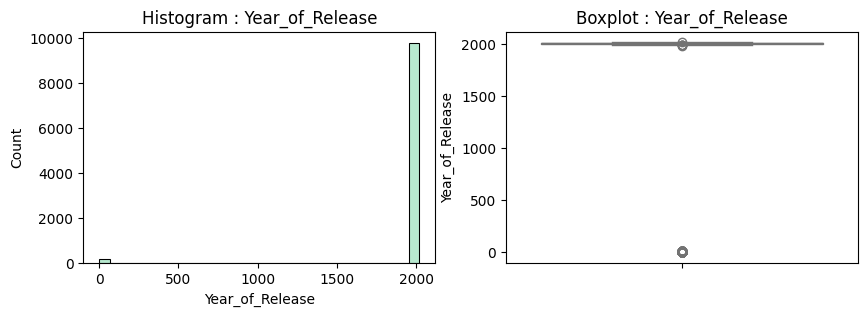

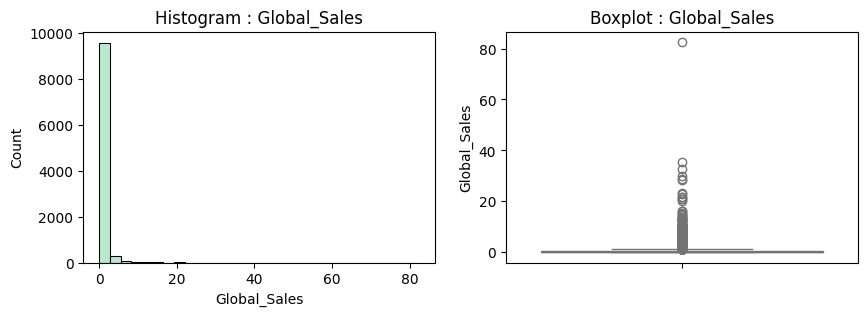

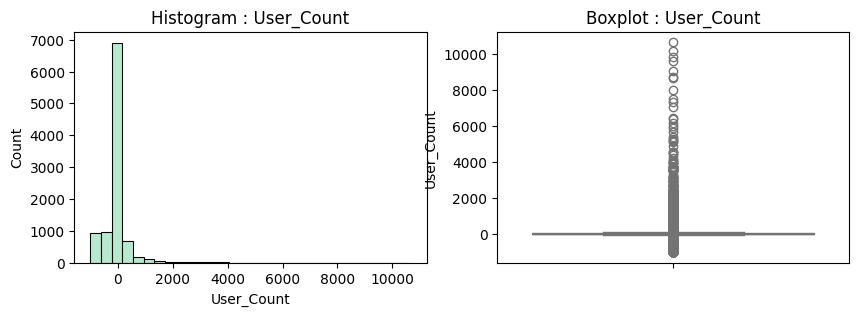

In [19]:
# Numerical Columns
def dist_check(df, columns):
  for c in columns:
    plt.figure(figsize = (10, 3))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[c],
                 bins = 30,
                 color = "#9FE2BF")
    plt.title(f"Histogram : {c}")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y = df[c],
                color = "#9FE2BF")
    plt.title(f"Boxplot : {c}")

    plt.show()

dist_check(data, numerical)

In [20]:
data[numerical].describe()

,Year_of_Release,Global_Sales,User_Count
count,9961.000000,9961.000000,9961.000000
mean,1971.600341,0.610180,0.130409
std,266.024458,1.660858,583.393187
min,1.000000,0.010000,-1000.000000
25%,2004.000000,0.080000,4.000000
50%,2008.000000,0.210000,14.000000
75%,2010.000000,0.570000,50.000000
max,2020.000000,82.530000,10665.000000


Based on the plots above, there are many outliers and imbalances on the dataset.
- The column **Year_of_Release** has some entries that don't make sense in real life application, so we will be dropping the observations (we will drop data that has the **Year_of_Release** before 1958, since first game was made on 1958 (https://www.thegamer.com/what-first-video-game/)).
- The column **User_Count** has negative values, also doesn't make sense, so we will drop the observations.

The other variables' outliers are relevant on a real life application, we won't be performing any further handling.

In [21]:
# Drop Year_of_Release
indices_to_drop = data[data["Year_of_Release"] < 1958].index
data = data.drop(indices_to_drop)
print(f"Year_of_Release dropped.")

Year_of_Release dropped.


In [22]:
# Drop User_Count
indices_to_drop = data[data["User_Count"] < 0].index
data = data.drop(indices_to_drop)
print(f"Negative User_Count dropped.")

Negative User_Count dropped.


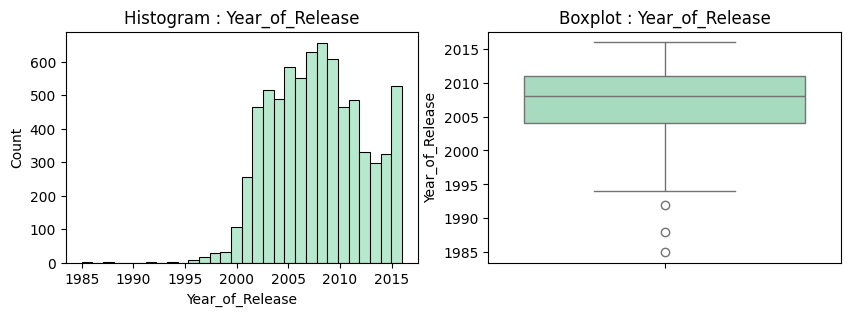

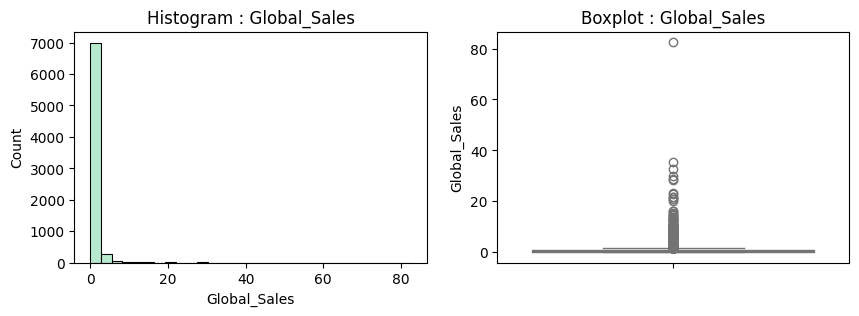

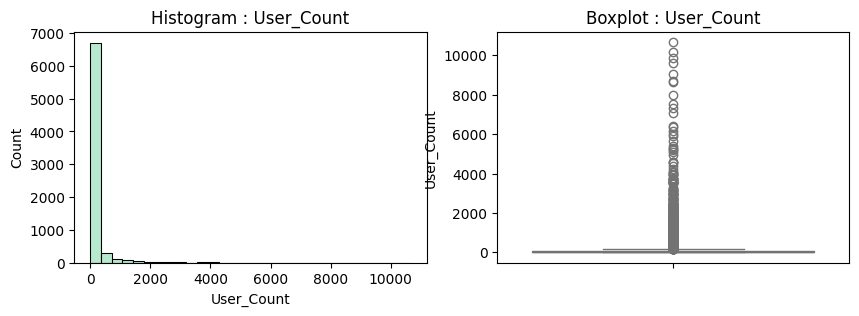

,Year_of_Release,Global_Sales,User_Count
count,7378.000000,7378.000000,7378.000000
mean,2007.640011,0.749676,163.521008
std,4.270536,1.898413,566.691144
min,1985.000000,0.010000,4.000000
25%,2004.000000,0.110000,10.000000
50%,2008.000000,0.280000,24.000000
75%,2011.000000,0.730000,81.000000
max,2016.000000,82.530000,10665.000000


In [23]:
# Recheck
dist_check(data, numerical)
data[numerical].describe()

Here, we have handled the outliers and chose the features for our system.

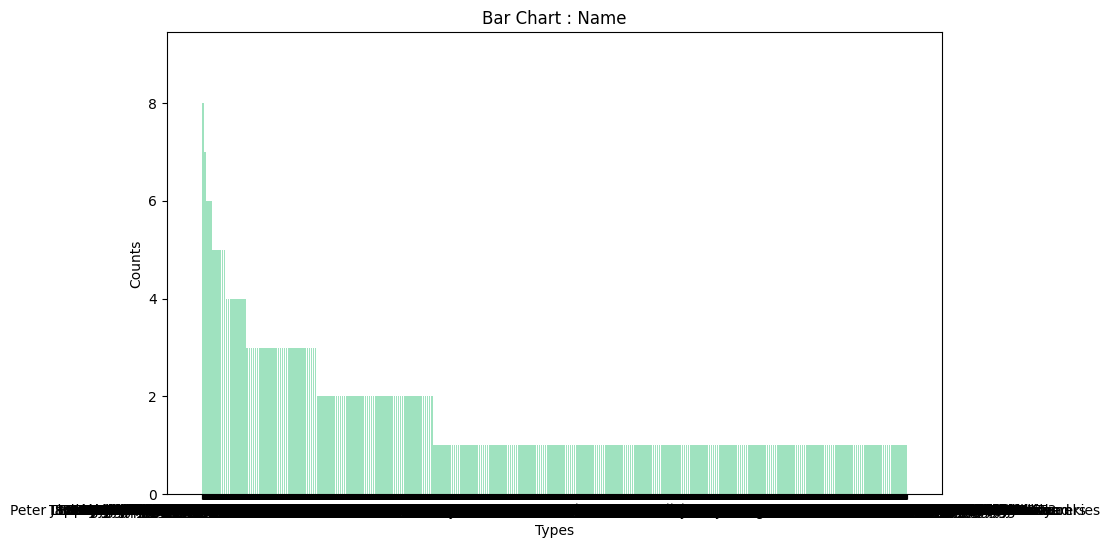

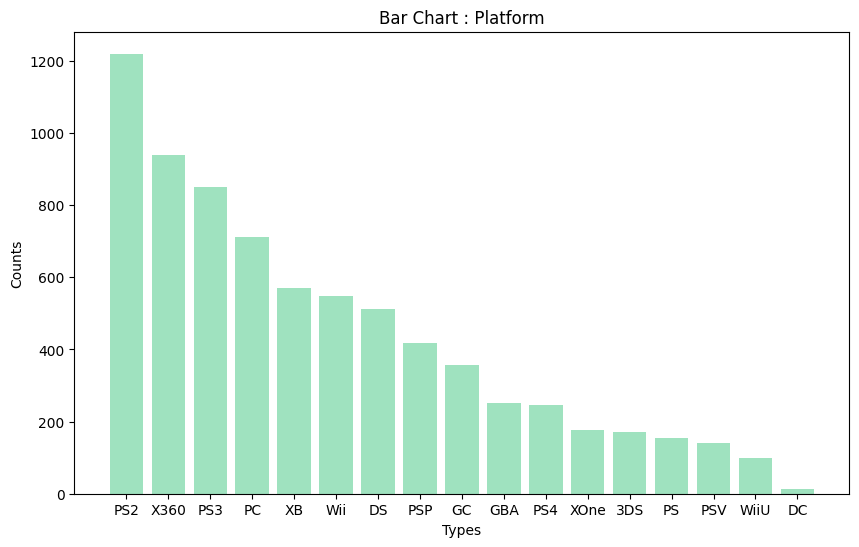

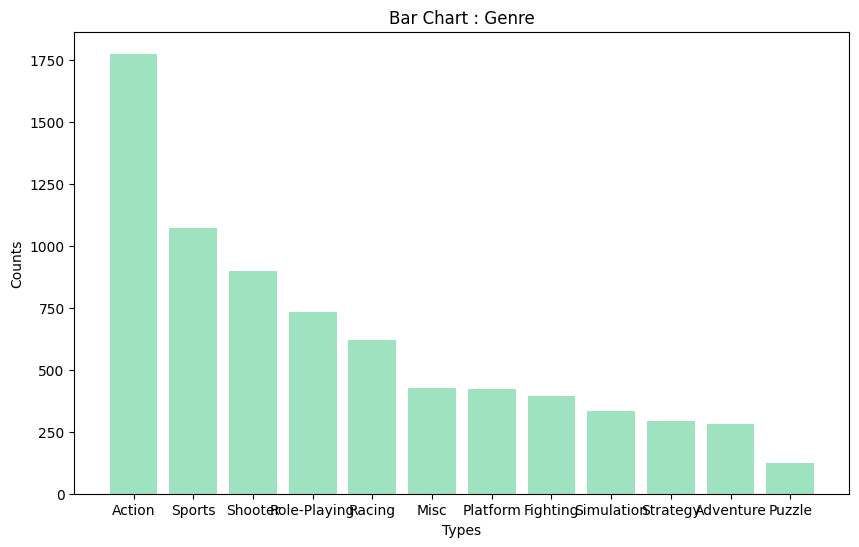

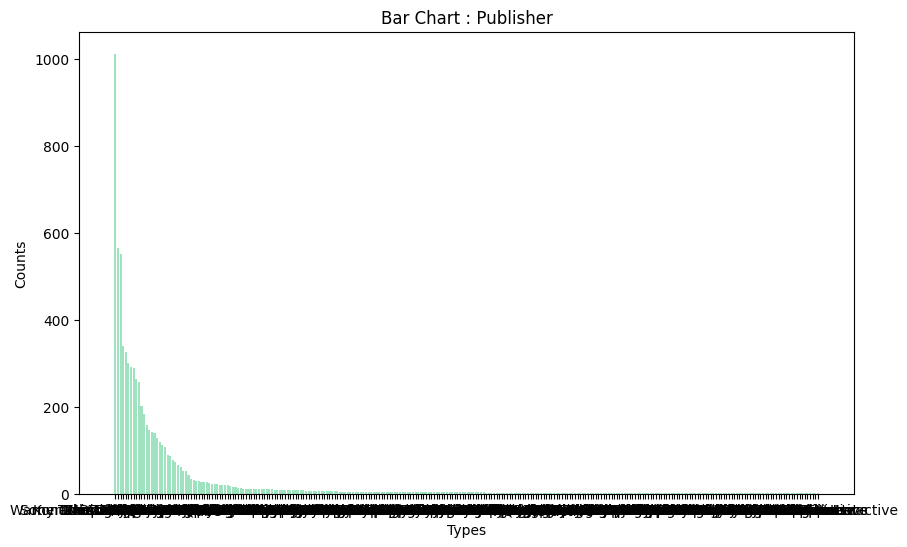

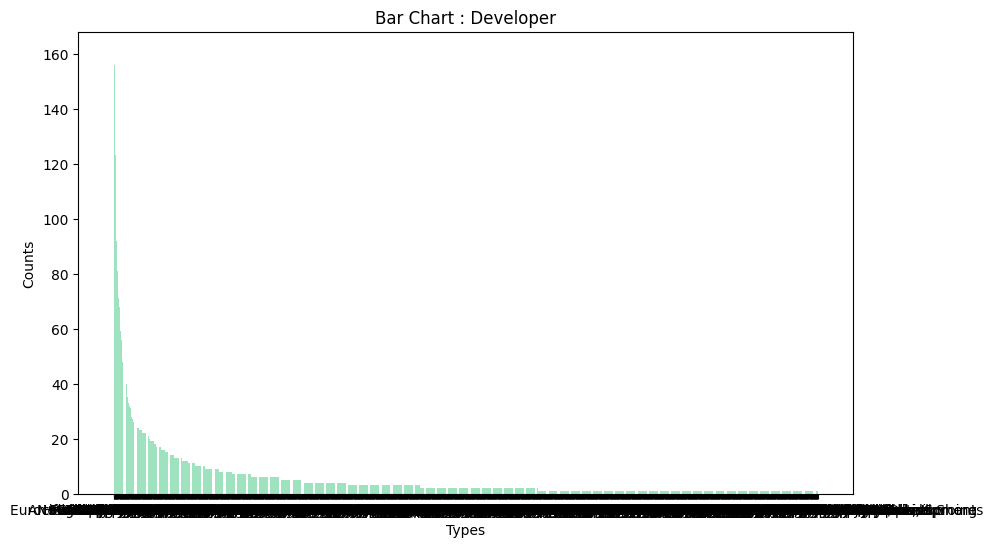

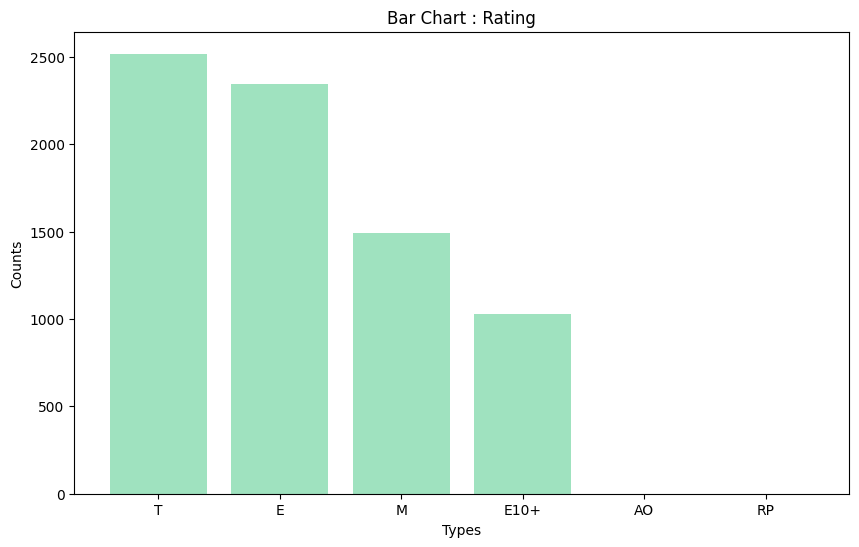

In [24]:
# Categorical Columns
def categorical_dist(df, columns):
  for c in columns:
    plt.figure(figsize = (10, 6))

    plt.bar(x = data[c].value_counts().index,
            height = data[c].value_counts().values,
            color = "#9FE2BF")
    plt.title(f"Bar Chart : {c}")
    plt.xlabel("Types")
    plt.ylabel("Counts")

    plt.show()

categorical_dist(data, categorical)

Based on the plots above:
- **Platform**: Majority of the games are on PS2 Platform, with over 1200 titles.
- **Genre**: Action games dominate as the most common genre, exceeding 1750 titles.
- **Rating**: Most are rated E (family friendly), with more than 2500 games.

Imbalances does exist. However, I believe these unique values are relevant for the recommender system, so we will simply ignore them.

### **CONTENT-BASED RECOMMENDER SYSTEM**

In [25]:
# Backup Dataset
df = data.copy()

#### **Create Combined Features**

In [26]:
df["combined_features"] = df["Platform"] + ", " + str(df["Year_of_Release"]) + ", " + df["Genre"] + ", " + df["Publisher"] + ", " + str(df["Global_Sales"]) + ", " + str(df["User_Count"]) + ", " + df["Developer"] + ", " + df["Rating"]
df.dropna(subset = ["combined_features"], inplace = True)

I created a new column, **combined_features**, by combining all the values from each observation into a string format for vectorization later.

#### **TF-IDF Vectorization**

In [27]:
tfidf_matrix = TfidfVectorizer(stop_words = "english").fit_transform(df["combined_features"]).toarray()
cosine_sim = linear_kernel(tfidf_matrix,
                           tfidf_matrix)

In the code above, I applied vectorization to convert the **combined_features** into numerical format, making it more interpretable for the recommender system.

#### **Recommender System**

In [28]:
def get_recommendations(name, cosine_sim = cosine_sim, num_recommend = 5):
    indices = pd.Series(df.index,
                        index = df['Name']).drop_duplicates()
    idx = indices[name].iloc[0] if isinstance(indices[name], pd.Series) else indices[name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores,
                        key = lambda x: x[1],
                        reverse = True)
    top_similar = sim_scores[1:num_recommend + 1]
    gameindices = [i[0] for i in top_similar]
    ret_df = pd.DataFrame(data.iloc[gameindices])
    ret_df["similarity"] = [i[1] for i in top_similar]
    return ret_df

In [29]:
def rec_system(input):
  print(f"Input: {input}")
  row = data[data["Name"] == input]
  display(row.iloc[:1])
  print("Recommendations:")
  display(get_recommendations(input))

### **EVALUATION**

In [30]:
input1 = "Halo 2"
rec_system(input1)

Input: Halo 2


,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,User_Count,Developer,Rating
52,Halo 2,XB,2004,Shooter,Microsoft Game Studios,8.49,1218.0,Bungie Software,M


Recommendations:


,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,User_Count,Developer,Rating,similarity
88,Halo: Combat Evolved,XB,2001,Shooter,Microsoft Game Studios,6.43,1283.0,Bungie Software,M,1.000000
2062,Halo 2 Multiplayer Map Pack,XB,2005,Shooter,Microsoft Game Studios,0.69,34.0,Bungie Software,M,1.000000
41,Halo: Reach,X360,2010,Shooter,Microsoft Game Studios,9.86,2045.0,Bungie,M,0.934233
29,Halo 3,X360,2007,Shooter,Microsoft Game Studios,12.12,4100.0,"Bungie Software, Bungie",M,0.918753
92,Halo 3: ODST,X360,2009,Shooter,Microsoft Game Studios,6.34,1163.0,"Bungie Software, Bungie",M,0.918753


Based on the first input, *Halo 2*, the system returns 5 recommendations:
- *Halo: Combat Evolved*
- *Halo 2 Multiplayer Map Pack*
- *Halo: Reach*
- *Halo 3*
- *Halo 3: ODST*

These games share similar features with the input.
- They are all developed by Bungie.
- They are all published by Microsoft Game Studios.
- They all belong to the shooting genre.
- They were released in the early 2000s.
- They are all rated as M (mature) games.

And they all have over 90% similarity with the input. This indicates that the model succeeded on giving recommendations for the first input.


In [31]:
input2 = "Wii Play"
rec_system(input2)

Input: Wii Play


,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,User_Count,Developer,Rating
4,Wii Play,Wii,2006,Misc,Nintendo,28.92,129.0,Nintendo,E


Recommendations:


,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,User_Count,Developer,Rating,similarity
232,Big Brain Academy: Wii Degree,Wii,2007,Misc,Nintendo,3.79,39.0,Nintendo,E,1.000000
293,Wii Music,Wii,2008,Misc,Nintendo,3.25,116.0,Nintendo,E,1.000000
1568,Wii Play: Motion,Wii,2011,Misc,Nintendo,0.92,16.0,Nintendo,E10+,0.982187
71,The Legend of Zelda: Twilight Princess,Wii,2006,Action,Nintendo,7.15,1658.0,Nintendo,T,0.956535
0,Wii Sports,Wii,2006,Sports,Nintendo,82.53,322.0,Nintendo,E,0.951201


Based on the second input, *Wii Play*, the system returns 5 recommendations:
- *Big Brain Academy: Wii Degree*
- *Wii Music*
- *Wii Play: Motion*
- *The Legend of Zelda: Twilight Princess*
- *Wii Sports*

The games also share similar features with the input.
- They are all played on Wii platform.
- They are all developed and published by Nintendo.
- They are all released in the early 2000s.
- Most of them are rated as family-friendly games.

They also have over 95% similarity with the input, which indicates that the model also succeeded on giving recommendations for the second input.


In [32]:
input3 = "Mario Kart DS"
rec_system(input3)

Input: Mario Kart DS


,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,User_Count,Developer,Rating
6,Mario Kart DS,DS,2005,Racing,Nintendo,23.21,464.0,Nintendo,E


Recommendations:


,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,User_Count,Developer,Rating,similarity
141,The Legend of Zelda: Phantom Hourglass,DS,2007,Action,Nintendo,5.08,416.0,Nintendo,E,0.962085
1882,Metroid Prime Hunters,DS,2006,Shooter,Nintendo,0.76,188.0,Nintendo,T,0.954413
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,35.52,709.0,Nintendo,E,0.944699
285,The Legend of Zelda: Spirit Tracks,DS,2009,Action,Nintendo,3.31,228.0,Nintendo,E10+,0.944343
12,Brain Age: Train Your Brain in Minutes a Day,DS,2005,Misc,Nintendo,20.15,50.0,Nintendo,E,0.944148


Based on the last input, *Mario Kart DS*, the system returns 5 recommendations:
- *The Legend of Zelda: Phantom Hourglass*
- *Metroid Prime Hunters*
- *Mario Kart Wii*
- *The Legend of Zelda: Spirit Tracks*
- *Brain Age: Train Your Brain in Minutes a Day*

The games also share similar features with the input.
- Most of them are played on the DS platform.
- They are developed and published by Nintendo.
- They are released in the early 2000s.
- Most of them are rated as family-friendly games.

They also have over 90% similarity with the input, which indicates that the model also succeeded on giving recommendations for the last input.


#### **Final Conclusion**

In conclusion, this recommendation system I made is pretty reliable to give game recommendations based on user inputs. The similarity scores exceeding 90% in all tests indicate the system’s success in identifying the most similar games for the user.

Additionally, this recommender system returns its suggestions mostly based on the similarity of **Platform**, **Publisher**, **Developer**, and **Rating**.